In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

from helper_funcs import *

In [5]:
zipdata = get_zipdata()
zipdata.shape

----pulling ZipCode data from Azure storage----
----Done----


(6987, 43)

In [6]:
#zipdata = zipdata.loc[zipdata.Population!=0]

#### Fill the following columns with 0 for NaN values

In [8]:
zipdata.loc[zipdata.over_65_ratio.isna(),'over_65_ratio'] = 0
zipdata.loc[zipdata.Hosp_count.isna(),'Hosp_count'] = 0
zipdata.loc[zipdata.HPI.isna(),'HPI'] = 0
zipdata.loc[zipdata.Demand_score.isna(),'Demand_score'] = 0
zipdata.loc[zipdata.Supply_score.isna(),'Supply_score'] = 0
zipdata.loc[zipdata.listviews_vs_US.isna(),'listviews_vs_US'] = 0
zipdata.loc[zipdata.med_days_on_mkt.isna(),'med_days_on_mkt'] = 0
zipdata.loc[zipdata.nielson_rank.isna(),'nielson_rank'] = 0
zipdata.loc[zipdata.Zillow_HVF.isna(),'Zillow_HVF'] = 0

#### Fill the following columns with the Mean for NaN values

In [9]:
zipdata.loc[zipdata.school_rating.isna(),'school_rating'] = 5
zipdata.loc[zipdata.UE_rate.isna(),'UE_rate'] = zipdata.UE_rate.mean()
zipdata.loc[zipdata.BEA_percap_income.isna(),'BEA_percap_income'] = zipdata.BEA_percap_income.mean()

#### Remove unused location data, and building permits data for now

In [10]:
zipdata.drop(columns=zipdata.columns[-13:], inplace=True)
zipdata.drop(columns=zipdata.columns[:5], inplace=True)

In [11]:
zipdata.isna().sum()

Population              0
HouseholdsPerZipCode    0
WhitePopulation         0
BlackPopulation         0
HispanicPopulation      0
AsianPopulation         0
IndianPopulation        0
OtherPopulation         0
MalePopulation          0
FemalePopulation        0
AverageHouseValue       0
IncomePerHousehold      0
MedianAge               0
NumberOfBusinesses      0
over_65_ratio           0
school_rating           0
Hosp_count              0
HPI                     0
Demand_score            0
Supply_score            0
listviews_vs_US         0
med_days_on_mkt         0
nielson_rank            0
UE_rate                 0
Zillow_HVF              0
dtype: int64

Check Some correlations

<AxesSubplot:>

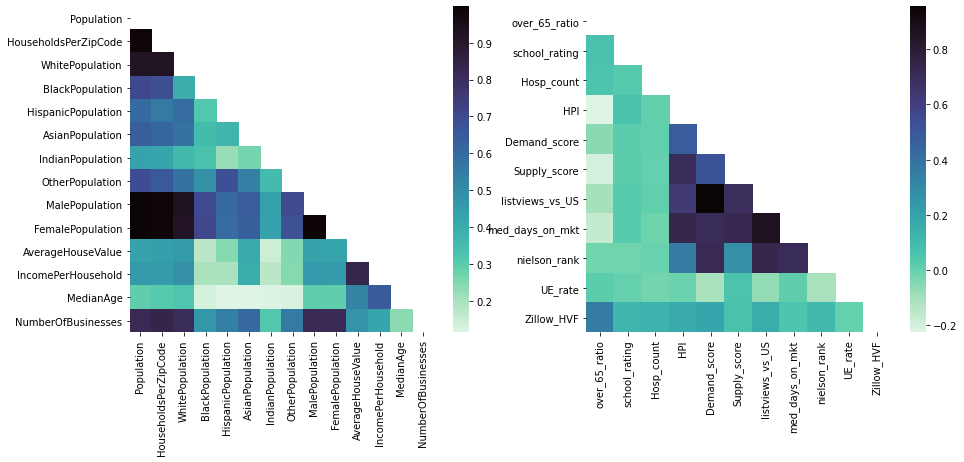

In [12]:
corr1 = zipdata.iloc[:,0:14].corr()
corr2 = zipdata.iloc[:,14:].corr()

mask1 = np.triu(np.ones_like(corr1, dtype=bool)) # Hide upper redundant heatmap
mask2 = np.triu(np.ones_like(corr2, dtype=bool)) # Hide upper redundant heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(corr1, mask=mask1, ax=ax[0], annot=False, cmap='mako_r')
sns.heatmap(corr2, mask=mask2, ax=ax[1], annot=False, cmap='mako_r')

Create Population Ratios

In [13]:
zipdata['Blacks_ratio'] = zipdata.BlackPopulation / zipdata.Population
zipdata['Hispanics_ratio'] = zipdata.HispanicPopulation / zipdata.Population
zipdata['Asians_ratio'] = zipdata.AsianPopulation / zipdata.Population
zipdata['Indians_ratio'] = zipdata.IndianPopulation / zipdata.Population
zipdata['Others_ratio'] = zipdata.OtherPopulation / zipdata.Population
zipdata['Male_ratio'] = zipdata.MalePopulation / zipdata.Population
zipdata.loc[zipdata.Blacks_ratio.isna(),'Blacks_ratio'] = 0
zipdata.loc[zipdata.Hispanics_ratio.isna(),'Hispanics_ratio'] = 0
zipdata.loc[zipdata.Asians_ratio.isna(),'Asians_ratio'] = 0
zipdata.loc[zipdata.Indians_ratio.isna(),'Indians_ratio'] = 0
zipdata.loc[zipdata.Others_ratio.isna(),'Others_ratio'] = 0
zipdata.loc[zipdata.Male_ratio.isna(),'Male_ratio'] = 0

zipdata.drop(columns=['BlackPopulation','HispanicPopulation','AsianPopulation','WhitePopulation',
                      'IndianPopulation','OtherPopulation','MalePopulation','FemalePopulation'], inplace=True)

<AxesSubplot:>

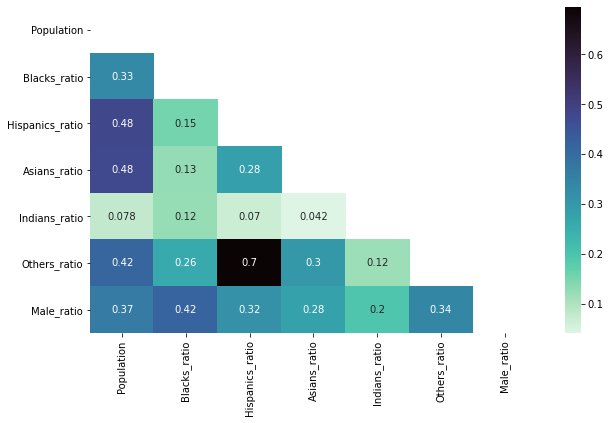

In [14]:
corrmatrix = zipdata[['Population', 'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 'Indians_ratio',
       'Others_ratio', 'Male_ratio']].corr()
mask = np.triu(np.ones_like(corrmatrix, dtype=bool)) # Hide upper redundant heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corrmatrix, mask=mask, annot=True, cmap='mako_r')

### 🎚️ Scale data before clustering

In [15]:
mms = MinMaxScaler()
# REMOVE AverageHouseValue
data_scaled = pd.DataFrame(mms.fit_transform(zipdata.drop(columns='AverageHouseValue').values), 
                           columns=zipdata.drop(columns='AverageHouseValue').columns, 
                           index=zipdata.drop(columns='AverageHouseValue').index)

### K-means Clustering of ZipCode data to produce desirability Clusters

In [16]:
kmeans = KMeans()
inertias = {}
for n in range(1,15):
    kmeans.set_params(n_clusters=n)
    kmeans.fit(data_scaled)
    inertias[n] = kmeans.inertia_

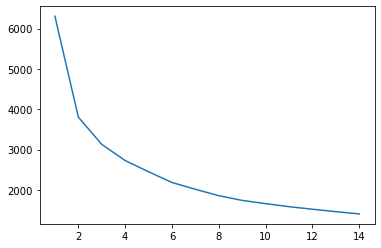

In [17]:
plt.plot(inertias.keys(),inertias.values())

#### Try 10 Clusters

In [18]:
kmeans.set_params(n_clusters=8)
kmeans.fit(data_scaled)
zipdata['cluster'] = kmeans.labels_

In [19]:
zipdata.columns

Index(['Population', 'HouseholdsPerZipCode', 'WhitePopulation',
       'AverageHouseValue', 'IncomePerHousehold', 'MedianAge',
       'NumberOfBusinesses', 'over_65_ratio', 'school_rating', 'Hosp_count',
       'HPI', 'Demand_score', 'Supply_score', 'listviews_vs_US',
       'med_days_on_mkt', 'nielson_rank', 'UE_rate', 'Zillow_HVF',
       'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 'Indians_ratio',
       'Others_ratio', 'Male_ratio', 'cluster'],
      dtype='object')

In [20]:
print(zipdata.groupby('cluster').agg('count')['Population'])
zipdata.groupby('cluster').agg('mean')[['AverageHouseValue','Population','over_65_ratio',
                                       'IncomePerHousehold','school_rating','Hosp_count',
                                       'HPI','UE_rate','Zillow_HVF','NumberOfBusinesses']].round(2).sort_values(by='AverageHouseValue')

cluster
0     622
1     807
2     574
3    2006
4     856
5     702
6     723
7     697
Name: Population, dtype: int64


,AverageHouseValue,Population,over_65_ratio,IncomePerHousehold,school_rating,Hosp_count,HPI,UE_rate,Zillow_HVF,NumberOfBusinesses
cluster,,,,,,,,,,
2,0.00,8.30,0.00,0.00,5.00,0.00,321.76,4.43,0.05,5.06
5,0.00,31.89,0.00,184.22,5.00,0.01,91.42,4.22,0.13,9.65
7,0.00,22.13,0.00,152.30,5.00,0.03,272.33,4.13,0.39,9.84
3,118425.87,3274.59,0.22,41187.21,4.98,0.03,18.49,4.23,4.90,61.54
0,137514.79,6358.27,0.20,47058.96,5.16,0.05,249.47,4.06,10.32,147.08
4,196226.40,19825.27,0.19,57932.29,5.22,0.09,286.65,4.21,17.09,530.75
1,219263.69,25167.40,0.18,60294.01,5.48,0.15,143.77,4.21,18.06,731.82
6,331894.74,15255.43,0.16,86952.27,5.37,0.06,304.77,4.46,9.16,391.53


## 🎰 Model with Clusters

In [2]:
RF = get_redfin_csv()
print(RF.shape)

----pulling Redfin data from Azure storage----
----Done----
(74717, 21)


In [3]:
RF.Detached.value_counts()

1    50224
0    24493
Name: Detached, dtype: int64

#### Merge cluster into House data

In [21]:
print(f'shape before merge: {RF.shape}')
RF = RF.merge(zipdata, how = 'left', left_on = 'zip', right_index=True)
RF.cluster = RF.cluster.astype('object')
print(f'shape after merge: {RF.shape}')

shape before merge: (74717, 21)
shape after merge: (74717, 46)


<AxesSubplot:xlabel='cluster', ylabel='PRICE'>

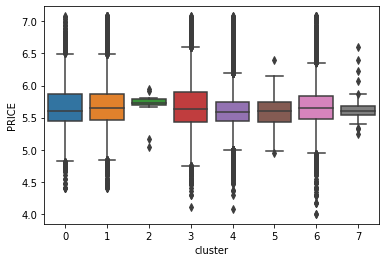

In [22]:
sns.boxplot(x=RF.cluster, y=np.log10(RF.PRICE))

In [292]:
#pd.set_option('display.max_rows', None)
zip_houses = RF.groupby('zip').agg('count')['PRICE'].to_dict()
RF['houses_perZIP'] = RF.zip.apply(lambda r: zip_houses[r])
RF = RF[RF.houses_perZIP>4]
# Use groupby to split the df into smaller dfs for each ZIP
groups = RF.groupby('zip')
dfs = [groups.get_group(x) for x in groups.groups]
# Use first df to initiate X_train, X_test, etc
for d in dfs[:1]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','cluster']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_train, X_test, y_train, y_test = train_test_split(feat, y)
# train_test_split each df then stack together
for d in dfs[1:]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','cluster']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
    X_train = X_train.append(X_trainpiece)
    X_test = X_test.append(X_testpiece)
    y_train = y_train.append(y_trainpiece)
    y_test = y_test.append(y_testpiece)
# Check rows
print(f'X_train rows: {X_train.shape}')
print(f'X_test rows: {X_test.shape}')

X_train rows: (54839, 8)
X_test rows: (19199, 8)


In [293]:
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum = pd.get_dummies(X_test, drop_first=True)

In [294]:
lm = LinearRegression()
lm.fit(X_train_dum, y_train)
print(f'train R2: {lm.score(X_train_dum, y_train)}')
print(f'train R2: {lm.score(X_test_dum, y_test)}')

train R2: 0.753986051860511
train R2: 0.727882801550633


## 🐱 Try CatBoost
* Label Encode **Prop_Type & zip**

In [295]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

le = LabelEncoder()
X_train_le.Prop_Type = le.fit_transform(X_train_le.Prop_Type)
X_test_le.Prop_Type = le.fit_transform(X_test_le.Prop_Type)
X_train_le.zip = le.fit_transform(X_train_le.zip)
X_test_le.zip = le.fit_transform(X_test_le.zip)

In [296]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_train_le, y_train)
print(f'Train R2: {cat.score(X_train_le, y_train)}')
print(f'Test R2: {cat.score(X_test_le, y_test)}')

Train R2: 0.8221543722226234
Test R2: 0.795604840626706


## Miniscule improvements with Cluster information

🦏 Try **Full** Model by directly adding ZipCode Level information & feature select with Lasso

In [23]:
# Use all columns except 
# PRICE, Sale_Type, Sold_Date, ADDRESS, CITY, State, px_perSF, HOA_perMonth, 
# Status, LATITUDE, LONGITUDE, LOCATION, Days_on_Mkt, AverageHouseValue
unwanted = ['PRICE','Sale_Type', 'Sold_Date', 'ADDRESS', 'CITY', 'State', 'LOCATION',
            'Days_on_Mkt', 'px_perSF', 'HOA_perMonth', 'STATUS', 'LATITUDE', 'LONGITUDE','AverageHouseValue']
RF.columns

Index(['Sale_Type', 'Sold_Date', 'Prop_Type', 'ADDRESS', 'CITY', 'State',
       'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SF', 'Lot_Size', 'YearBuilt',
       'Days_on_Mkt', 'px_perSF', 'HOA_perMonth', 'STATUS', 'LATITUDE',
       'LONGITUDE', 'zip', 'Detached', 'Population', 'HouseholdsPerZipCode',
       'WhitePopulation', 'AverageHouseValue', 'IncomePerHousehold',
       'MedianAge', 'NumberOfBusinesses', 'over_65_ratio', 'school_rating',
       'Hosp_count', 'HPI', 'Demand_score', 'Supply_score', 'listviews_vs_US',
       'med_days_on_mkt', 'nielson_rank', 'UE_rate', 'Zillow_HVF',
       'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 'Indians_ratio',
       'Others_ratio', 'Male_ratio', 'cluster'],
      dtype='object')

In [24]:
#pd.set_option('display.max_rows', None)
zip_houses = RF.groupby('zip').agg('count')['PRICE'].to_dict()
RF['houses_perZIP'] = RF.zip.apply(lambda r: zip_houses[r])
RF = RF[RF.houses_perZIP>4]
# Use groupby to split the df into smaller dfs for each ZIP
groups = RF.groupby('zip')
dfs = [groups.get_group(x) for x in groups.groups]
# Use first df to initiate X_train, X_test, etc
for d in dfs[:1]:
    feat = d.drop(columns=unwanted)
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_train, X_test, y_train, y_test = train_test_split(feat, y)
# train_test_split each df then stack together
for d in dfs[1:]:
    feat = d.drop(columns=unwanted)
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
    X_train = X_train.append(X_trainpiece)
    X_test = X_test.append(X_testpiece)
    y_train = y_train.append(y_trainpiece)
    y_test = y_test.append(y_testpiece)
# Check rows
print(f'X_train rows: {X_train.shape}')
print(f'X_test rows: {X_test.shape}')

X_train rows: (54473, 33)
X_test rows: (19083, 33)


In [25]:
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum = pd.get_dummies(X_test, drop_first=True)
lasso = Lasso()
lasso.set_params(normalize=True, max_iter=10000, random_state=44)
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 10000,
 'normalize': True,
 'positive': False,
 'precompute': False,
 'random_state': 44,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [26]:
#try different alphas
alphas = np.linspace(0.00001,0.00005,10)
coefs_lasso = []
R2_train = []
R2_test = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_dum, y_train)
    coefs_lasso.append(lasso.coef_)
    R2_train.append(lasso.score(X_train_dum, y_train))
    R2_test.append(lasso.score(X_test_dum, y_test))

In [27]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train_dum.columns)
R2_lasso = pd.DataFrame({'train': R2_train,'test':R2_test}, index = alphas)
coefs_lasso.head(2)

,BEDS,BATHS,SF,Lot_Size,YearBuilt,Detached,Population,HouseholdsPerZipCode,WhitePopulation,IncomePerHousehold,...,zip_34990,zip_34994,zip_34996,zip_34997,cluster_1,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0.000010,-0.006276,0.049752,0.000122,0.0,0.000691,0.094936,-0.000000e+00,0.0,-0.000005,0.000002,...,0.0,0.0,0.047018,-0.0,0.0,-0.0,-0.021849,0.000428,0.008329,0.000269
0.000014,-0.003896,0.049183,0.000122,0.0,0.000539,0.071537,-1.501475e-07,0.0,-0.000005,0.000002,...,0.0,0.0,0.000000,-0.0,0.0,0.0,-0.024031,0.000086,0.000000,0.000092


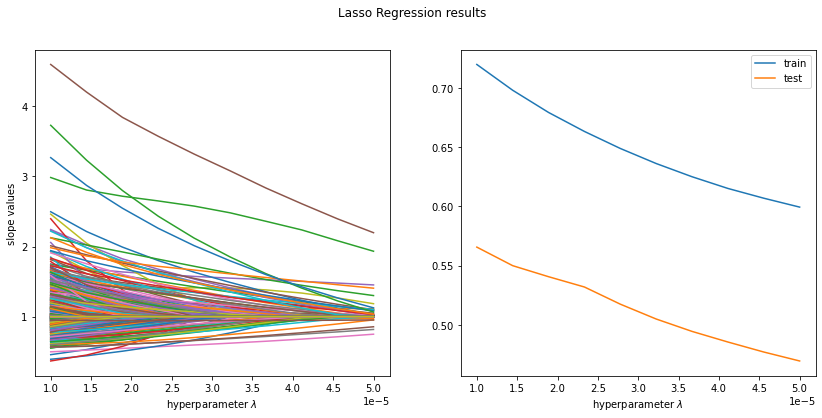

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Lasso Regression results')

for feat in coefs_lasso.columns:
    ax1.plot(coefs_lasso.index, 10**coefs_lasso[feat]) 
ax1.set_xlabel(r'hyperparameter $\lambda$')
ax1.set_ylabel(r'slope values')
#ax1.legend(loc=1)
for each in R2_lasso.columns:
    ax2.plot(R2_lasso.index, R2_lasso[each], label=each)
ax2.set_xlabel(r'hyperparameter $\lambda$')
ax2.legend(loc=1)

In [29]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

le = LabelEncoder()
X_train_le.Prop_Type = le.fit_transform(X_train_le.Prop_Type)
X_test_le.Prop_Type = le.fit_transform(X_test_le.Prop_Type)
X_train_le.zip = le.fit_transform(X_train_le.zip)
X_test_le.zip = le.fit_transform(X_test_le.zip)

In [32]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_train_le, y_train)
print(f'Train R2: {cat.score(X_train_le, y_train)}')
print(f'Test R2: {cat.score(X_test_le, y_test)}')

Train R2: 0.8874877093188094
Test R2: 0.85569362757157


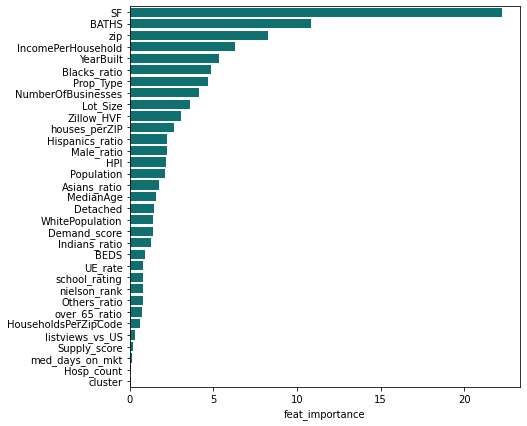

In [33]:
feat_importances = pd.DataFrame(cat.get_feature_importance(), index=X_train_le.columns, columns=['feat_importance'])
feat_importances = feat_importances.sort_values(by='feat_importance', ascending=False)

f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='feat_importance', y=feat_importances.index, data=feat_importances, color="teal");

In [53]:
Cat_scores = []

for num in range(3,len(feat_importances.index)):
    print(num)
    groups = RF.groupby('zip')
    dfs = [groups.get_group(x) for x in groups.groups]
    # Use first df to initiate X_train, X_test, etc
    for d in dfs[:1]:
        feat = d[[*feat_importances.index[:num]]]
        feat.zip = feat.zip.astype('object')
        y = np.log10(d.PRICE)
        X_train, X_test, y_train, y_test = train_test_split(feat, y, test_size=0.25)
    # train_test_split each df then stack together
    for d in dfs[1:]:
        feat = d[[*feat_importances.index[:num]]]
        feat.zip = feat.zip.astype('object')
        y = np.log10(d.PRICE)
        X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
        X_train = X_train.append(X_trainpiece)
        X_test = X_test.append(X_testpiece)
        y_train = y_train.append(y_trainpiece)
        y_test = y_test.append(y_testpiece)
    X_train.zip = le.fit_transform(X_train.zip)
    X_test.zip = le.fit_transform(X_test.zip)
    if 'Prop_Type' in X_train.columns:
        X_train.Prop_Type = le.fit_transform(X_train.Prop_Type)
        X_test.Prop_Type = le.fit_transform(X_test.Prop_Type)
    
    cat.fit(X_train, y_train)
    Cat_scores.append(cat.score(X_test, y_test))

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


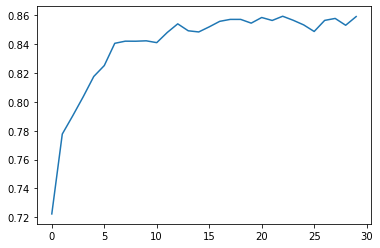

In [54]:
plt.plot(Cat_scores)